<a href="https://colab.research.google.com/github/elijahcw-git/Capstone/blob/main/LSTM_Earlystopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from math import ceil, sqrt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
crime_df = pd.read_csv('/content/drive/MyDrive/clean_df_1Mar2024.csv')

In [ ]:
print(f"Dataset shape :{crime_df.shape}\n")


missing_values = crime_df.isnull().sum()
percentage_missing = (missing_values / len(crime_df)) * 100
unique_values = crime_df.nunique()
summary_df = print(pd.DataFrame({'Data_type': crime_df.dtypes,'Missing': missing_values, '%_Missing': percentage_missing, 'Unique_values': unique_values}))

print(summary_df)

Dataset shape :(2883802, 26)

                     Data_type  Missing  %_Missing  Unique_values
DR_NO                    int64        0        0.0        2555000
Date_Rptd               object        0        0.0           5129
DATE_OCC                object        0        0.0           5111
TIME_OCC                 int64        0        0.0           1439
AREA                     int64        0        0.0             21
AREA_NAME               object        0        0.0             21
Rpt_Dist_No              int64        0        0.0           1302
Part_1-2                 int64        0        0.0              2
Crm_Cd                   int64        0        0.0            144
Crm_Cd_Desc             object        0        0.0            144
Vict_Age               float64        0        0.0             99
Vict_Sex                object        0        0.0              3
Vict_Descent            object        0        0.0             21
LOCATION                object        0       

In [ ]:
crime_df['DATE_OCC'] = pd.to_datetime(crime_df['DATE_OCC'])
crime_df.head(5)

,DR_NO,Date_Rptd,DATE_OCC,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1-2,Crm_Cd,Crm_Cd_Desc,...,Avg_Temp,Avg_Dewpoint,Avg_Humidity,Avg_Windspeed,Avg_Pressure,Total_Precipitation,Crime_Category,Crime_Category_Code,Region_Ethnic_Origin,Weapon_Reported
0,1307355,02/20/2010 12:00:00 AM,2010-02-20,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,56.1,47.5,73.2,9.7,29.8,0.0,Violations and Restraining Orders,7,Hispanic/Latin/Mexican,0
1,100100638,02/20/2010 12:00:00 AM,2010-02-20,100,1,Central,164,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,56.1,47.5,73.2,9.7,29.8,0.0,Vandalism and Property Damage,6,Other,0
2,100100639,02/20/2010 12:00:00 AM,2010-02-20,230,1,Central,164,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,...,56.1,47.5,73.2,9.7,29.8,0.0,"Assault, Battery and Other Violent",0,Hispanic/Latin/Mexican,1
3,100106650,02/20/2010 12:00:00 AM,2010-02-20,45,1,Central,155,2,624,BATTERY - SIMPLE ASSAULT,...,56.1,47.5,73.2,9.7,29.8,0.0,"Assault, Battery and Other Violent",0,Black,1
4,100106654,02/20/2010 12:00:00 AM,2010-02-20,1130,1,Central,146,2,946,OTHER MISCELLANEOUS CRIME,...,56.1,47.5,73.2,9.7,29.8,0.0,Miscellaneous Crimes,2,Hispanic/Latin/Mexican,0


In [ ]:
crime_df['AREA_NAME'] = crime_df['AREA_NAME'].astype('category')

In [ ]:
crime_df['Crime_Incidence'] = crime_df.groupby(['AREA_NAME', 'DATE_OCC'])['AREA_NAME'].transform('count')

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import mean_squared_error
import math
from math import floor,ceil,sqrt
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def lstm_prediction(crime_df):
    shape = crime_df.shape[0]
    df_new = crime_df[['Crime_Incidence']]
    dataset = df_new.values
    train = df_new[:ceil(shape*0.80)]
    valid = df_new[ceil(shape*0.80):]

    print('---------------------------------------------------------------------------------------')
    print('-----------L.A. CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('---------------------------------------------------------------------------------------')
    print('Shape of Training Set', train.shape)
    print('Shape of Validation Set', valid.shape)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40, len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=64))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs = scaler.transform(inputs)
    X_test = []
    for i in range(40, inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms = sqrt(mean_squared_error(valid, crime_predictions))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence', 'Predictions']])
    plt.xlabel('DATE_OCC', size=15)
    plt.ylabel('Amount of Crime Incidences', size=15)
    plt.title('L.A. CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)', size=15)
    plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])
    plt.show()

---------------------------------------------------------------------------------------
-----------L.A. CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
---------------------------------------------------------------------------------------
Shape of Training Set (2307042, 1)
Shape of Validation Set (576760, 1)
Epoch 1/50
57676/57676 - 345s - loss: 0.0013 - val_loss: 6.6066e-04 - 345s/epoch - 6ms/step
Epoch 2/50
57676/57676 - 339s - loss: 0.0012 - val_loss: 6.6198e-04 - 339s/epoch - 6ms/step
Epoch 3/50
57676/57676 - 339s - loss: 0.0012 - val_loss: 6.5902e-04 - 339s/epoch - 6ms/step
Epoch 4/50
57676/57676 - 339s - loss: 0.0012 - val_loss: 6.6401e-04 - 339s/epoch - 6ms/step
Epoch 5/50
57676/57676 - 341s - loss: 0.0012 - val_loss: 7.1849e-04 - 341s/epoch - 6ms/step
Epoch 6/50
57676/57676 - 345s - loss: 0.0012 - val_loss: 6.6232e-04 - 345s/epoch - 6ms/step
Epoch 7/50
57676/57676 - 347s - loss: 0.0012 - val_loss: 7.4063e-04 - 347s/epoch - 6ms/step
Epoch 8/50
57676/57676

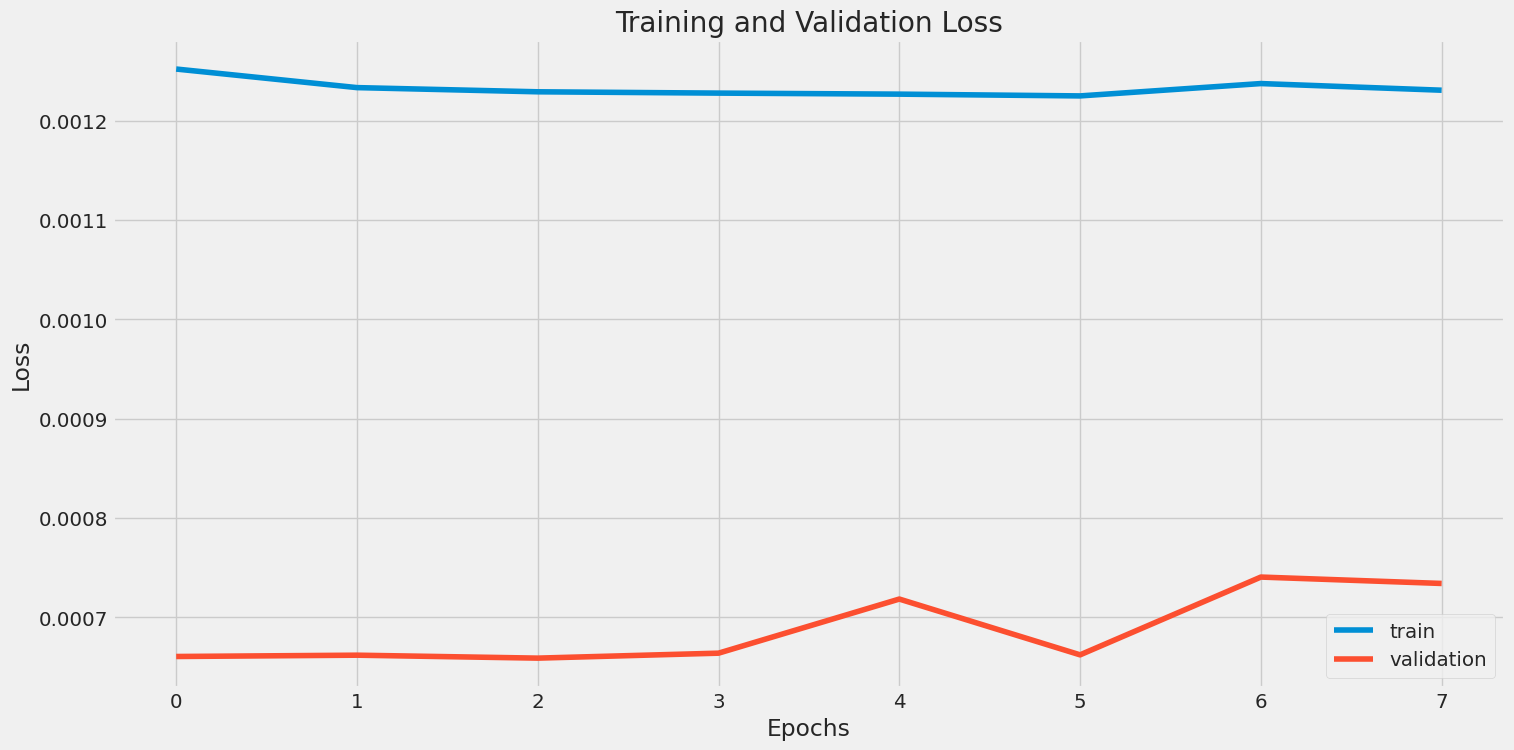

18024/18024 [==============================] - 50s 3ms/step
RMSE value on validation set: 16.652542682457895
-----------------------------------------------------------
-----------------------------------------------------------


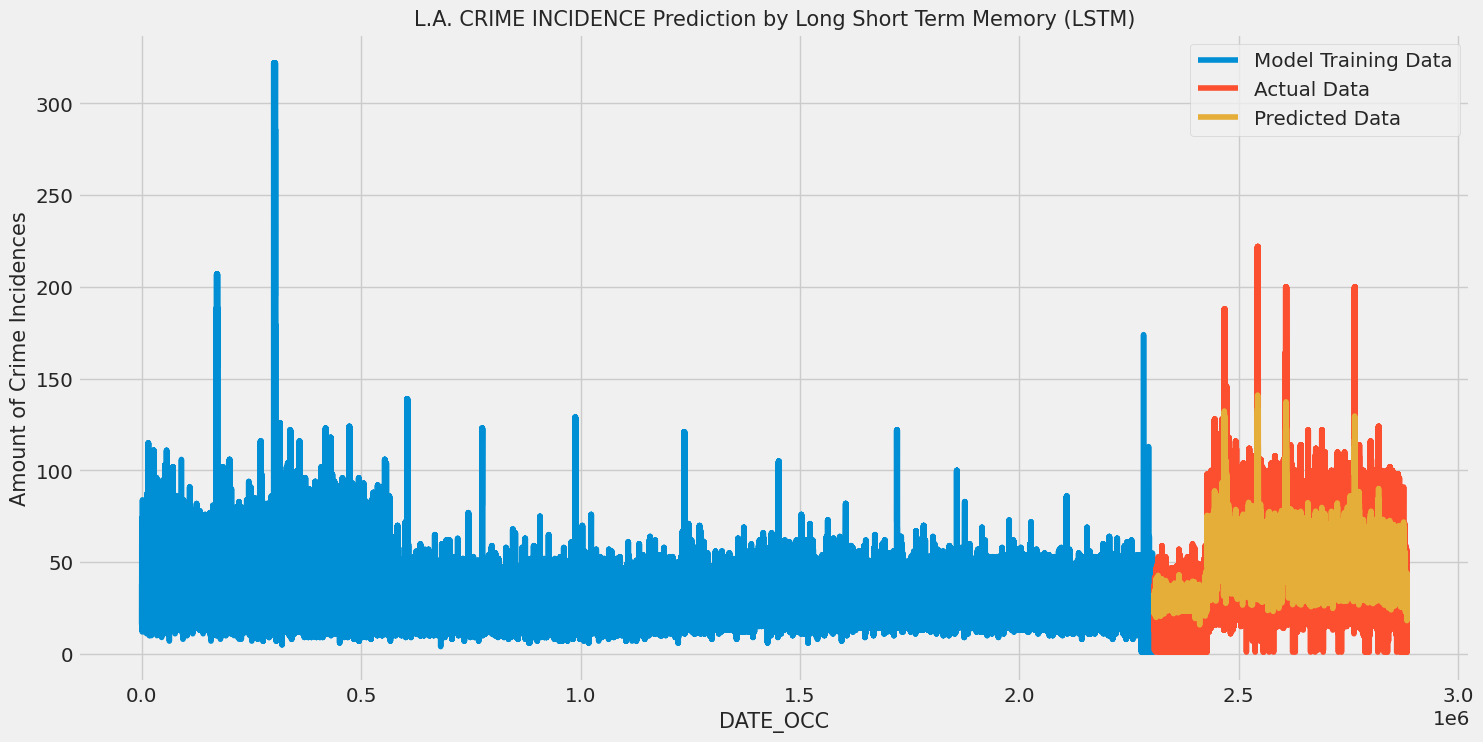

In [ ]:
lstm_prediction(crime_df)